In [59]:
import pandas as pd
import os
import re

def process_parquet(filename, working_dir, db_values=[5, 10, 15]):
    """
    Process a Parquet file, aggregate power by deadband (°F), and
    return a dict of Series like {'DB_15_120': <Series>, ...}.
    """
    file_path = os.path.join(working_dir, filename)
    df = pd.read_parquet(file_path)

    # Ensure datetime is rounded
    df['Time'] = df['Time'].dt.round('min')

    # Convert Celsius → Fahrenheit
    df['DB_F'] = df['Deadband_C'] * 9 / 5
    df = df.drop(columns=['Deadband_C'])

    results = {}

    # Extract the numeric part from "Shed120" for suffix
    match = re.search(r"Shed(\d+)", filename)
    suffix = match.group(1) if match else "125"

    for db in db_values:
        df_db = df[df['DB_F'] == db]
        if df_db.empty:
            print(f"⚠️ No data found for {db}°F in {filename}")
            continue

        # print(df_db.columns)    

        power_sum = df_db.groupby('Time')['Water Heating Electric Power (kW)'].sum()
        upDB = df_db.groupby('Time')['Water Heating Deadband Upper Limit (C)'].mean()
        key = f"DB_{int(db)}_{suffix}"
        results[key] = power_sum
        # results[key] = {
        #     "power": power_sum,
        #     "upDB": upDB
        # }
    return results


In [60]:
WORKING_DIR = r"C:\Users\danap\OCHRE_Working"

files = [
    "180110_1_3_Shed110_Control.parquet",
    "180110_1_3_Shed115_Control.parquet",
    "180110_1_3_Shed120_Control.parquet",
    "180110_1_3_ShedLong125_Control.parquet",
    "180110_1_3_Shed105_Control.parquet",
    "180110_1_3_Shed100_Control.parquet"
]

all_results = {}
for f in files:
    res = process_parquet(f, WORKING_DIR)
    all_results.update(res)

print(all_results.keys())
# print(all_results["DB_15_120"].head())



dict_keys(['DB_5_110', 'DB_10_110', 'DB_15_110', 'DB_5_115', 'DB_10_115', 'DB_15_115', 'DB_5_120', 'DB_10_120', 'DB_15_120', 'DB_5_125', 'DB_10_125', 'DB_15_125', 'DB_5_105', 'DB_10_105', 'DB_15_105', 'DB_5_100', 'DB_10_100', 'DB_15_100'])


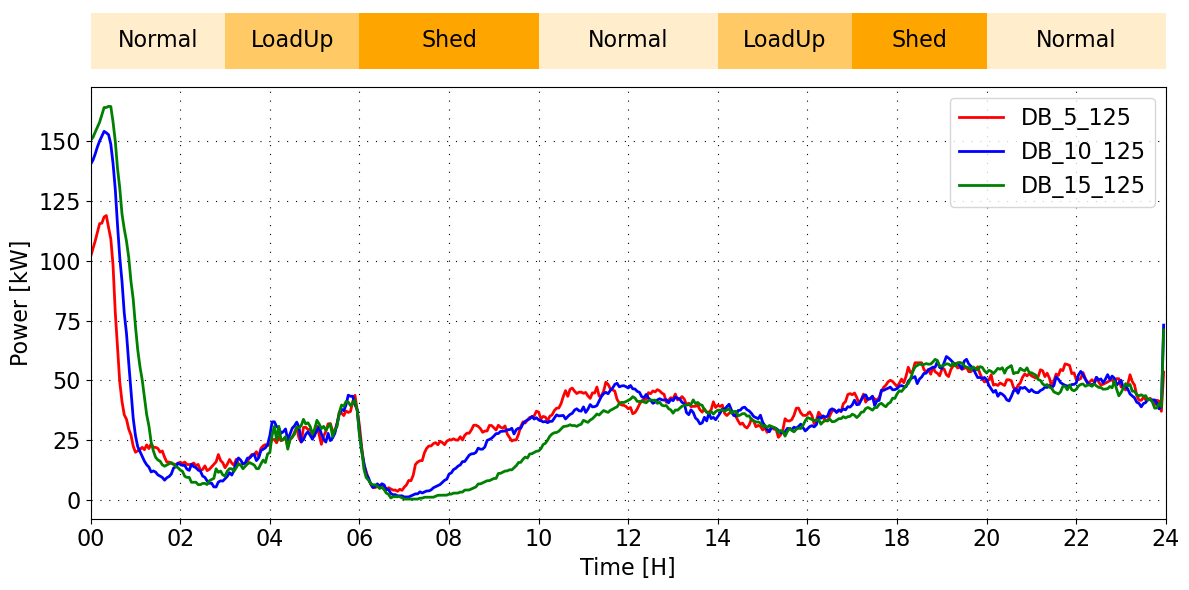

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

A = 16

# -------------------------------
# Example bars subplot data
# -------------------------------
results = {'': [3, 3, 4, 4, 3, 3, 4]}
words = ['Normal', 'LoadUp', 'Shed', 'Normal', 'LoadUp', 'Shed', 'Normal']

def bars(ax, results, category_names):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    
    Alpha = [0.2, 0.6, 1, 0.2, 0.6, 1, 0.2]
    text_color = ['black'] * len(category_names)

    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_xlim(0, np.sum(data, axis=1).max())
    
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)
    
    for i, colname in enumerate(category_names):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, color='orange', edgecolor='none', alpha=Alpha[i])
        for j, rect in enumerate(rects):
            ax.text(rect.get_x() + rect.get_width()/2,
                    rect.get_y() + rect.get_height()/2,
                    category_names[i],
                    ha='center', va='center', color=text_color[i], fontsize=A)


# -------------------------------
# Select deadbands to plot
# -------------------------------
# Pick any 1–2 keys from all_results
keys_to_plot = ["DB_5_125", "DB_10_125", "DB_15_125"]  # example
DB_list = [all_results[k] for k in keys_to_plot]
# DB_upLIST = DB_list = [all_results[k]["upDB"] for k in keys_to_plot]

DB_values_F = [int(k.split("_")[1]) for k in keys_to_plot]
labels = [f"{k}" for k in keys_to_plot]  # or f"DB {db}°F"

colors = ['red', 'blue', 'green', 'orange', 'purple', 'black']

# -------------------------------
# Create figure and axes
# -------------------------------
fig, (ax_bars, ax_control) = plt.subplots(
    2, 1, figsize=(12, 6), 
    gridspec_kw={'height_ratios':[1, 7]}, 
    sharex=False
)

# Horizontal bars (example)
bars(ax_bars, results, words)

# -------------------------------
# Plot deadband curves
# -------------------------------
for i, db_series in enumerate(DB_list):
    if db_series.empty:
        print(f"{keys_to_plot[i]} is empty")
        continue

    # Ensure index is datetime
    if not np.issubdtype(db_series.index.dtype, np.datetime64):
        db_series.index = pd.to_datetime(db_series.index)

    # Convert datetime to numeric hours
    hours = (db_series.index - db_series.index[0]).total_seconds() / 3600

    ax_control.plot(hours, db_series.values, color=colors[i], linewidth=2, label=labels[i])

ax_control.set_ylabel("Power [kW]", fontsize=A)
ax_control.set_xlabel("Time [H]", fontsize=A)
ax_control.tick_params(axis='x', labelrotation=0, labelsize=A)
ax_control.tick_params(axis='y', labelsize=A)

# X-axis formatting
ax_control.set_xlim(0, 24)
ax_control.set_xticks(range(0, 25, 2))
ax_control.set_xticklabels([f"{h:02d}" for h in range(0, 25, 2)])

ax_control.grid(True, linestyle=(0, (1, 7)), color='black', linewidth=0.8)
ax_control.legend(fontsize=A)

plt.tight_layout()
plt.show()


In [7]:
# 


In [20]:
import os
import pandas as pd
import re

def aggregate_by_setpoint(work_dir):
    """
    Aggregate all per-deadband HPWH control files for the same setpoint (ShedXXX)
    into a single master file per setpoint.
    """
    # List all files in the directory
    all_files = [f for f in os.listdir(work_dir) if f.endswith("_Control.parquet") and "_DB" in f]

    # Group files by setpoint using regex
    setpoint_groups = {}
    for f in all_files:
        match = re.search(r"(Shed\d+)_DB\d+F_Control\.parquet", f)
        if match:
            setpoint = match.group(1)
            setpoint_groups.setdefault(setpoint, []).append(os.path.join(work_dir, f))

    # Aggregate each setpoint group
    for setpoint, files in setpoint_groups.items():
        all_dfs = []
        for file_path in files:
            df = pd.read_parquet(file_path)
            # Optional: keep track of deadband in df
            df["SourceFile"] = os.path.basename(file_path)
            all_dfs.append(df)
        df_master = pd.concat(all_dfs, ignore_index=True)
        master_file = os.path.join(work_dir, f"{setpoint}_Control.parquet")
        df_master.to_parquet(master_file, index=False)
        print(f"Aggregated {len(files)} files for {setpoint} → {master_file}")
